# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns


<span style="color: yellow;">- In 2.2 check if StandardScaler is good or if RobustScaler is better, for now it should be fine</span> 

<span style="color: red;">- ORA MODIFICO IL MODO DI STANDARDIZZARE -> STANDARDIZZAZIONE GLOBALE così:</span>
- Preservati i rapporti relativi: z_250 resta sempre > z_500 > z_850
- Mantiengo le distanze verticali: spessore della troposfera conservato
- Conservo la stagionalità: inverno vs estate mantengono le differenze assolute
- problemi numerici risolti: tutte le feature hanno scala simile per PCA/clustering


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
import geopandas as gpd
import geodatasets


## 1 Data Loading and Initial Analysis

The dataset used in this analysis consists of ERA5 reanalysis data downloaded from the Copernicus Climate Data Store (CDS). ERA5 is the fifth generation ECMWF atmospheric reanalysis providing comprehensive meteorological data with high spatial and temporal resolution. The dataset covers a 5-year period from January 1, 2000 to December 31, 2004, focusing on the European region. It includes four key atmospheric variables: geopotential height (z), temperature (t), and horizontal wind components (u, v), measured at three pressure levels (850 hPa, 500 hPa, and 250 hPa) on a regular 0.25° × 0.25° grid. This high-resolution gridded data provides a comprehensive representation of European atmospheric patterns and will be used to identify meteorological configurations through unsupervised clustering methods.

In [2]:
try:
    ds = xr.open_dataset('era5_ridotto.grib', engine= 'cfgrib') # XArray DataSet
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


In [3]:
print("Overview of the dataset:")
print(f"   • Variables: {list(ds.data_vars.keys())}")
print(f"   • Coordinates: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variables: ['z']
   • Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [4]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")


Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2


In [5]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f"   • Spatial points: {total_spatial_points}")
print(f"   • Total features per timestep: {total_features:,}")
print(f"   • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
   • Spatial points: 64521
   • Total features per timestep: 193,563
   • Temporal samples: 1827


In [6]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Struttura inziale dei dati

**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli

**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 21 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 1 foglio 

**Un foglio contiene i valori di una variabile** =  variabile: z -> <span style="color: red;">1 variabile</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 193,563 valori per blocco**   x 1827 giorni

Per la variabile z: 
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Se penso al foglio come una tabella con 193,563 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno, posso mettere insieme tutti i 1827 fogli, e ottenere una matrice finale di forma (1827, 193,563). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.


#### Struttura finale dei dati

L’obiettivo è trasformare tutto in una tabella 2D:

           feature_1  feature_2  ...  feature_193,563 
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  

Righe: 1827 (una per ogni timestep)  
Colonne: 193,563 (una per ogni combinazione di punto spaziale × variabile)  

In [7]:
# Convert dataset to 2D array 
def prepare_data_matrix(dataset):
    """Converts xarray dataset to 2D matrix"""
    data_matrices = {}
    
    for var in dataset.data_vars:
        print(f"   • Processing {var}...")
        var_data = dataset[var]
        
        # Reorganize dimensions: (time, features)
        if 'time' in var_data.dims:
            # Stack all non-temporal dimensions
            spatial_dims = [dim for dim in var_data.dims if dim != 'time']
            if spatial_dims:
                stacked = var_data.stack(features=spatial_dims)      # From: var[time=1827, pressure=3, lat=201, lon=321]
                matrix = stacked.values  # shape: (time, features)   # To:  var[time=1827, features=193563]  (3×201×321=193563)
            else:
                matrix = var_data.values.reshape(-1, 1)  # For variables without spatial dimensions
        else:
            matrix = var_data.values.flatten().reshape(1, -1)
        
        data_matrices[var] = matrix
    
    # Concatenate all variables
    all_matrices = list(data_matrices.values())
    combined_matrix = np.concatenate(all_matrices, axis=1) # concatenate along the columns (horizontally)

    return combined_matrix, data_matrices


In [8]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...
Data Matrix: (1827, 193563) (samples, features)
Data Matrix: (1827, 193563) (samples, features)


### 2.2 Standardization

For the standardization process, we initially implemented a per-feature standardization approach, where each spatial point was normalized with respect to its local temporal variability. However, this approach presents a significant limitation: all physical relationships between pressure levels (z₂₅₀ > z₅₀₀ > z₈₅₀) are lost, and the vertical structure of the troposphere becomes distorted.

To address this issue, we adopted a global standardization approach. This method preserves the relative relationships between pressure levels and maintains the atmospheric depth structure. Additionally, it ensures that all features have comparable scales, which is essential for subsequent analyses such as PCA and clustering, while retaining the meteorological interpretability of the data.

In [9]:
print("GLOBAL STANDARDIZATION - Preserving Meteorological Relationships")

global_mean = X.mean()
global_std = X.std()
X = (X - global_mean) / global_std

print(f"Global mean: {global_mean:.2f}m")
print(f"Global std: {global_std:.2f}m")
print(f"Dataset shape: {X.shape}")

print("Standardization verification:")
print(f"   • New global mean: {X.mean():.6f}")
print(f"   • New global std: {X.std():.6f}")

# Verify some sample statistics
print(f"   • Sample min: {X.min():.3f}")
print(f"   • Sample max: {X.max():.3f}")
print(f"   • Sample range: {X.max() - X.min():.3f}")



GLOBAL STANDARDIZATION - Preserving Meteorological Relationships
Global mean: 57405.69m
Global std: 36090.11m
Dataset shape: (1827, 193563)
Standardization verification:
   • New global mean: 0.000007
Global mean: 57405.69m
Global std: 36090.11m
Dataset shape: (1827, 193563)
Standardization verification:
   • New global mean: 0.000007
   • New global std: 0.999999
   • Sample min: -1.383
   • Sample max: 1.424
   • New global std: 0.999999
   • Sample min: -1.383
   • Sample max: 1.424
   • Sample range: 2.807
   • Sample range: 2.807


PRIMA della standardizzazione:  
Colonna 0 (z_850_lat0_lon0): Valori di geopotenziale a 850hPa nel punto (lat0,lon0) per TUTTI i 1827 giorni  
Esempio: [10815, 10820, 10805, 10830, ...] → 1827 valori diversi  

DOPO la standardizzazione:  
Colonna 0: Calcolo mean e std di quei 1827 valori  
Esempio: mean=10818, std=15  
Ogni valore diventa: (valore_originale - 10818) / 15  
Risultato: [-0.2, 0.13, -0.87, 0.8, ...] → media=0, std=1  

Cosa Significa:
La standardizzazione normalizza ogni punto geografico-variabile rispetto alla sua variabilità temporale.

Valore standardizzato = 0:

Il valore originale è esattamente uguale alla media  
Esempio: se media z_850hPa = 10820m e il valore standardizzato = 0, allora il valore originale era 10820m  
Valore standardizzato > 0 (positivo):  

Il valore originale è superiore alla media    
Esempio: z_standardized = +1.5 significa che il valore originale era 1.5 deviazioni standard sopra la media  
Se σ = 15m, allora il valore originale era: 10820 + (1.5 × 15) = 10842.5m  
Valore standardizzato < 0 (negativo):  

Il valore originale è inferiore alla media  
Esempio: z_standardized = -2.0 significa che il valore originale era 2.0 deviazioni standard sotto la media  
Se σ = 15m, allora il valore originale era: 10820 + (-2.0 × 15) = 10790m  
Regola pratica:  
z_std ≈ 0: valore normale (vicino alla media)  
z_std = ±1: moderatamente alto/basso (68% dei dati è tra -1 e +1)  
z_std = ±2: abbastanza estremo (95% dei dati è tra -2 e +2)  
z_std > ±3:  molto raro 

Now, an esample of standardization for 3 points is shown.

<span style="color: skyblue;">Capire cosa significa quella distribuzione gaussiana delle features, ho capito cosa significa normalizzare, ma capire meglio!</span> --> La densità mostra quali valori di pressione sono più frequenti  
- z_850hPa normale ≈ 10820m: densità alta (≈ 0.02-0.03) → valore comune  
- z_850hPa estremo = 14000m: densità bassa (0.0005) → evento molto raro!

<span style="color: skyblue;">Capire se con la normalizzazione perdo l'informazione nell'altezza tra i 3 lv di pressione</span>  -->

**le relazioni si mantengono completamente! MA I VALORI ASSOLUTI VENGONO PERSI** 

La correlazione tra due variabili X e Y **non cambia** dopo standardizzazione:
```
corr(X_standard, Y_standard) = corr(X_original, Y_original)
```

Quindi la relazione tra z_250 e z_500 resta identica prima e dopo la normalizzazione!


![image-2.png](attachment:image-2.png)

### 2.3 Principal Component Analysis

For what concern the Principal Component Analysis we have implemented an incremental pca in order to avoid numerical issues if we are dealing with huge datsets. In any case, the incremental pca converges to the same result of the standard pca.

Step 1: PCA Incrementale  
L'obiettivo è di riuscire a descrivere un dato sistema in modo chiaro e sufficientemente accurato
usando un numero ridotto di variabili, mantenendo il più possibile l’informazione (varianza) contenuta nei dati originali.  

IncrementalPCA elabora i dati un batch alla volta (100 righe) e aggiorna i componenti principali progressivamente.

<span style="color: orange;">Non adatta se:  
le variabili originali hanno un significato interpretativo importante (perché le componenti PCA sono combinazioni lineari difficili da interpretare)</span>



**Varianza = quanto i dati si "spargono" attorno alla media**
- La PCA cerca le **direzioni di MASSIMA varianza**   
- Trova i pattern meteorologici che cambiano di più nel tempo  
- Cattura le configurazioni atmosferiche principali (NAO, anticicloni, ecc.)  

<span style="color: orange;"> La PCA non assegna etichette o categorie: ogni campione rimane un punto nello spazio, solo rappresentato in modo più efficiente. Le componenti non sono cluster, ma assi cartesiani scelti in modo che la varianza sia massima lungo il primo asse, poi il secondo ecc. Quindi la PCA non è un clustering, anche se può rivelare struttura nei dati.

Principal components are a sequence of projections of the data, mutually uncorrelated and ordered in variance.   
The principal components of a set of data in IRp provide a sequence of best
linear approximations to that data, of all ranks q ≤ p.  
(BookAdvanced, pg 553)

In [ ]:
print("INCREMENTAL PCA ANALYSIS")

n_components = 30   # Reduced to 60 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Fit the PCA incrementally
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    ipca.partial_fit(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        gc.collect()

# Transform data in batches to avoid memory issues
X_pca = np.zeros((X.shape[0], n_components))

for i in range(0, X.shape[0], batch_size):
    end_idx = min(i + batch_size, X.shape[0])
    batch = X[i:end_idx]
    X_pca[i:end_idx] = ipca.transform(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        gc.collect()

print(f"   • Original shape: {X.shape}")
print(f"   • PCA shape: {X_pca.shape}")

# Analyze explained variance
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n   • VARIANCE ANALYSIS:")
print(f"   • Total explained variance ({n_components} components): {cumulative_variance[-1]:.3f}")

# Find components needed for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_comp_needed = np.argmax(cumulative_variance >= threshold) + 1
    if cumulative_variance[-1] >= threshold:
        print(f"   • {threshold*100}% variance: {n_comp_needed} components")
    else:
        print(f"   • {threshold*100}% variance: >{n_components} components needed")

# Show variance distribution for first components
print(f"\n   • First 10 components variance: {explained_variance_ratio[:10]}")
print(f"   • First 30 components cumulative: {cumulative_variance[29]:.3f}")

INCREMENTAL PCA ANALYSIS
   • Target components: 30
   • Batch size: 100
   • Data shape: (1827, 193563)
   • PCA transformation completed!
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 30)

   • VARIANCE ANALYSIS:
   • Total explained variance (30 components): 0.977
   • 80.0% variance: 5 components
   • 85.0% variance: 6 components
   • 90.0% variance: 9 components
   • 95.0% variance: 17 components

   • First 10 components variance: [0.54175443 0.09899399 0.08343008 0.06019424 0.0448536  0.02799979
 0.01898389 0.01710956 0.01276842 0.00937222]
   • First 30 components cumulative: 0.977
   • PCA transformation completed!
   • Original shape: (1827, 193563)
   • PCA shape: (1827, 30)

   • VARIANCE ANALYSIS:
   • Total explained variance (30 components): 0.977
   • 80.0% variance: 5 components
   • 85.0% variance: 6 components
   • 90.0% variance: 9 components
   • 95.0% variance: 17 components

   • First 10 components variance: [0.54175443 0.09899399 0.08343008 0.06019

La PCA con 60 componenti spiega l’98.3% della varianza totale.  

Il grafico mostra chiaramente un forte “elbow” nei primi componenti: la prima componente da sola spiega il 26.2% (!), la seconda il 7.1%, e poi via via la varianza scende rapidamente → significa che gran parte dell’informazione è concentrata nei primi component

    Analisi della varianza

    calcola la percentuale di varianza spiegata da ciascun componente  
    calcola la cumulata (cioè quanto “copre” l’informazione aggiungendo via via più componenti)  
    stampa quante componenti servono per spiegare almeno l’80%, 90%, 95% della varianza



- la prima componente da sola spiega il 42% della varianza → fortemente dominante
- le prime 10 componenti arrivano circa al 85% cumulato


VARIANCE VISUALIZATION


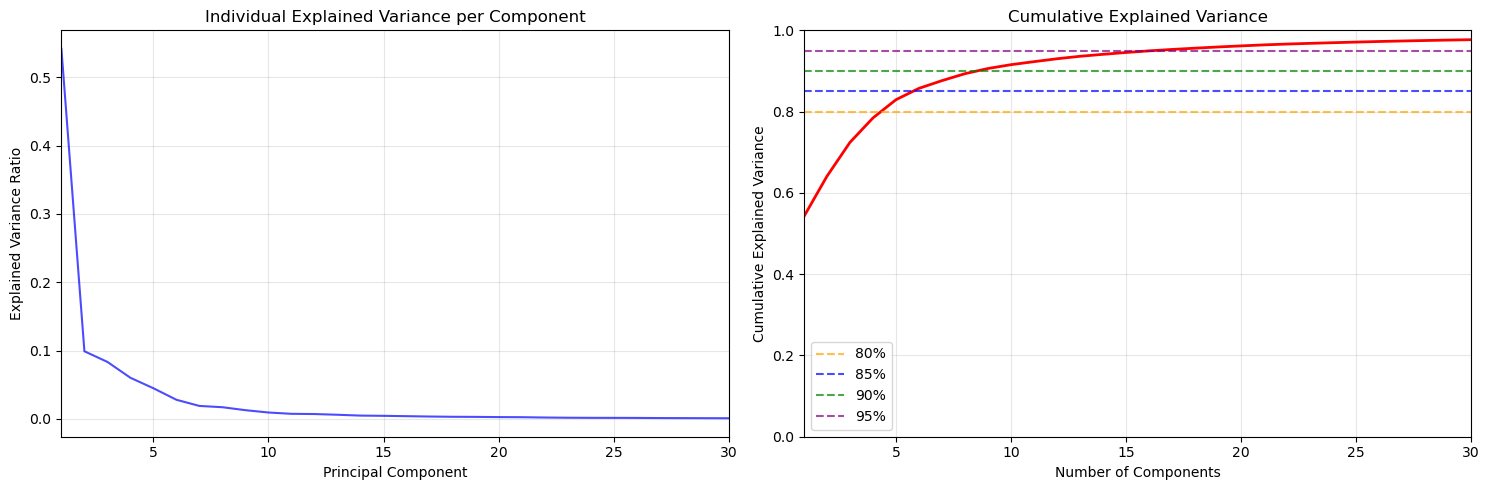

In [11]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Individual explained variance ratio
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-', alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance per Component')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, n_components) 

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
ax2.axhline(y=0.80, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.85, color='blue', linestyle='--', alpha=0.7, label='85%')
ax2.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, n_components)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Grafico a sinistra: varianza spiegata individualmente da ciascuna componente (curve blu decrescente).

Grafico a destra: varianza cumulativa spiegata dalle componenti, con linee orizzontali alle soglie 80%, 90%, 95% per capire visivamente quanti componenti servono.

    grafico a sinistra: varianza spiegata per singola componente
    (di solito decresce velocemente, “elbow” shape)  
    mostra la varianza spiegata da ciascun componente  
    conferma che la prima componente è molto informativa  
    curva a gomito → tipico nei dati ridondanti

    grafico a destra: varianza spiegata cumulata
    (sale a gradini, fino a saturare verso 1)  
    mostra la varianza cumulata
    le linee orizzontali (80%, 90%, 95%) ti fanno capire quanto margine hai  
    la curva rossa sale rapidamente ma si stabilizza, quindi i componenti successivi hanno impatto minore

<span style="color: orange;">la PCA permette di proiettare i dati in un nuovo spazio ridotto che mantiene la maggior parte dell’informazione
Inoltre, facilita interpretazioni fisiche (ad esempio i primi componenti possono corrispondere a pattern meteorologici dominanti) e riduce il rumore e la ridondanza tra variabili</span>

In [12]:
n_components_final = 30  # Final number of components based on variance analysis
print(f"   • Original data shape: {X.shape}")
print(f"   • PCA full shape: {X_pca.shape}")

variance_explained = cumulative_variance[n_components_final-1]
print(f"   • Actual variance explained: {variance_explained:.3f} ({variance_explained*100:.1f}%)")


   • Original data shape: (1827, 193563)
   • PCA full shape: (1827, 30)
   • Actual variance explained: 0.977 (97.7%)


#### 2.3.1 Visualization of the first components

I plots 2D/3D servono per:

- PC1 vs PC2: scatter plot per vedere se ci sono cluster naturali
- PC1 vs PC2 vs PC3: scatter 3D per pattern più complessi
- Istogrammi delle prime 4-5 componenti  
Se vedo "nuvole" separate → suggerisce struttura a cluster

VISUALIZATION OF PRINCIPAL COMPONENTS


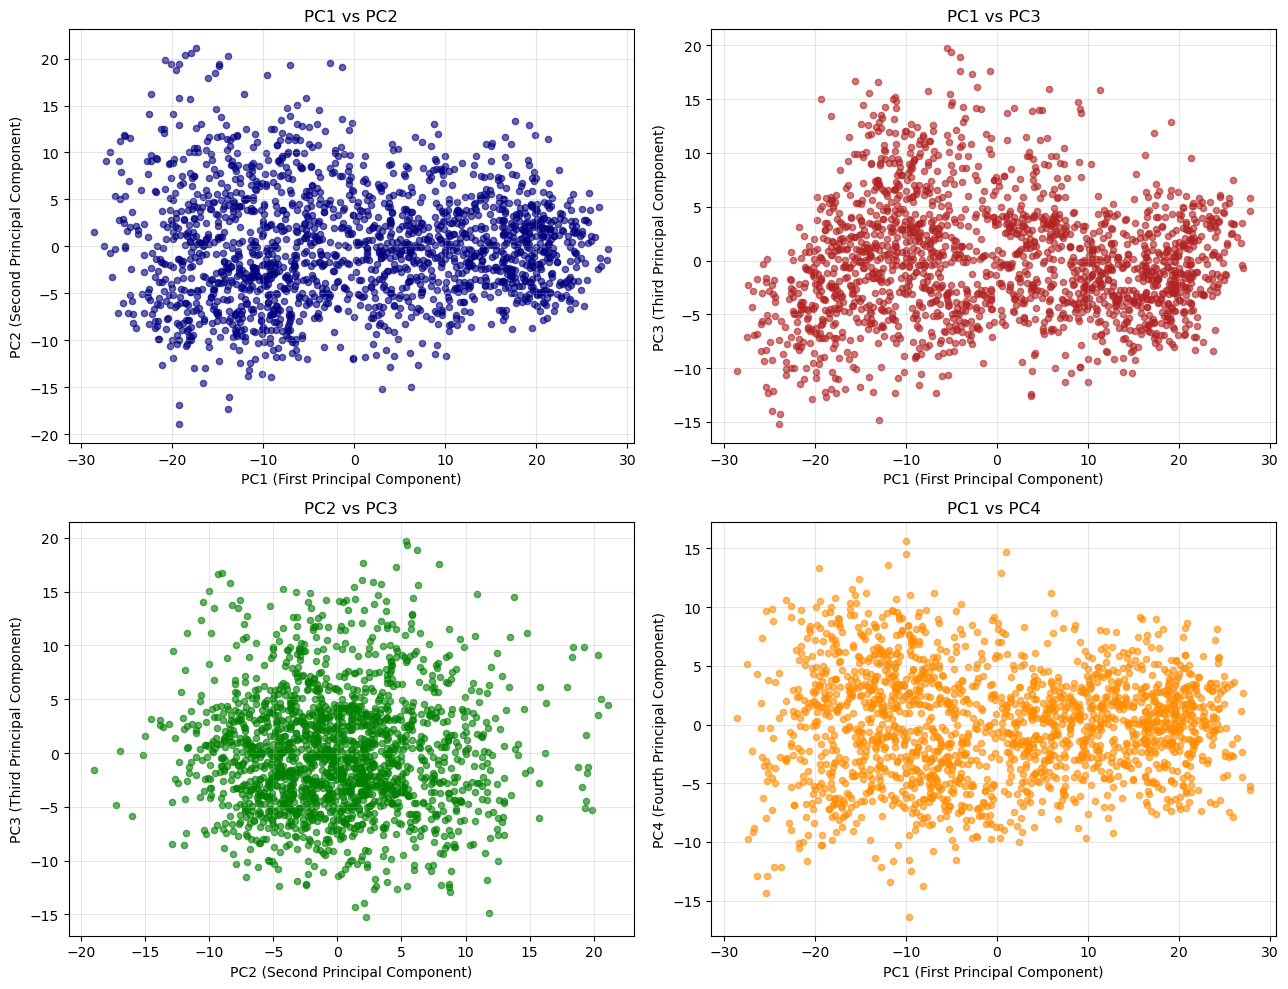

In [13]:
print("VISUALIZATION OF PRINCIPAL COMPONENTS")

# 1. SCATTER PLOT 2D: PC1 vs PC2
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))

ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=20, c='navy')
ax1.set_xlabel('PC1 (First Principal Component)')
ax1.set_ylabel('PC2 (Second Principal Component)')
ax1.set_title('PC1 vs PC2')
ax1.grid(True, alpha=0.3)

# PC1 vs PC3 scatter
ax2.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.6, s=20, c='firebrick')
ax2.set_xlabel('PC1 (First Principal Component)')
ax2.set_ylabel('PC3 (Third Principal Component)')
ax2.set_title('PC1 vs PC3')
ax2.grid(True, alpha=0.3)

# PC2 vs PC3 scatter
ax3.scatter(X_pca[:, 1], X_pca[:, 2], alpha=0.6, s=20, c='green')
ax3.set_xlabel('PC2 (Second Principal Component)')
ax3.set_ylabel('PC3 (Third Principal Component)')
ax3.set_title('PC2 vs PC3')
ax3.grid(True, alpha=0.3)

# PC1 vs PC4 scatter
ax4.scatter(X_pca[:, 0], X_pca[:, 3], alpha=0.6, s=20, c='darkorange')
ax4.set_xlabel('PC1 (First Principal Component)')
ax4.set_ylabel('PC4 (Fourth Principal Component)')
ax4.set_title('PC1 vs PC4')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



<span style="color: skyblue;">Capire cosa rappresentano i puntini</span> --> La posizione del puntino è determinata dalle sue coordinate proiettate su due componenti principali.

**PC1 vs PC2**: Two distinct clusters are clearly visible, indicating good separation between different meteorological configurations. PC1 appears to capture a primary discriminant direction that effectively separates the data into distinct atmospheric patterns. This suggests that PC1 represents the most significant mode of variability in European weather patterns, potentially corresponding to major synoptic-scale phenomena.

**PC2 vs PC3 and PC1 vs PC3**: The separation between clusters is less pronounced in these projections. PC3 captures more dispersed variance, suggesting it represents secondary meteorological patterns that are more spatially or temporally distributed. The weaker clustering indicates that PC3 may correspond to regional-scale variations or transitional weather states.

**PC1 vs PC4**: PC4 shows minimal evident structure and appears to contain less discriminative information. This component likely represents either background noise or minor meteorological variations that contribute less to the overall atmospheric configuration patterns.


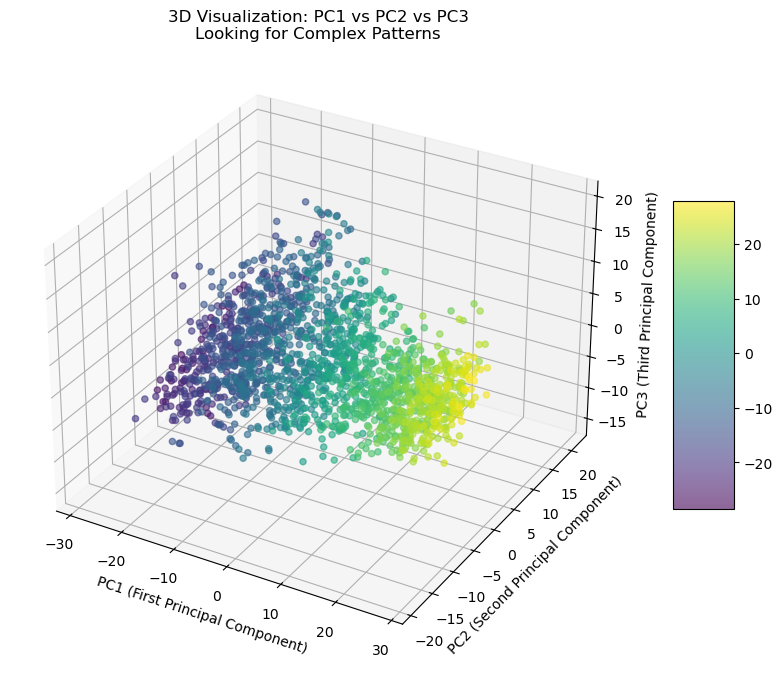

In [14]:
# 2. SCATTER PLOT 3D: PC1 vs PC2 vs PC3
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    alpha=0.6, s=20, c=X_pca[:, 0], cmap='viridis')
ax.set_xlabel('PC1 (First Principal Component)')
ax.set_ylabel('PC2 (Second Principal Component)')
ax.set_zlabel('PC3 (Third Principal Component)')
ax.set_title('3D Visualization: PC1 vs PC2 vs PC3\nLooking for Complex Patterns')

# Add colorbar
plt.colorbar(scatter, shrink=0.5, aspect=5)
plt.show()



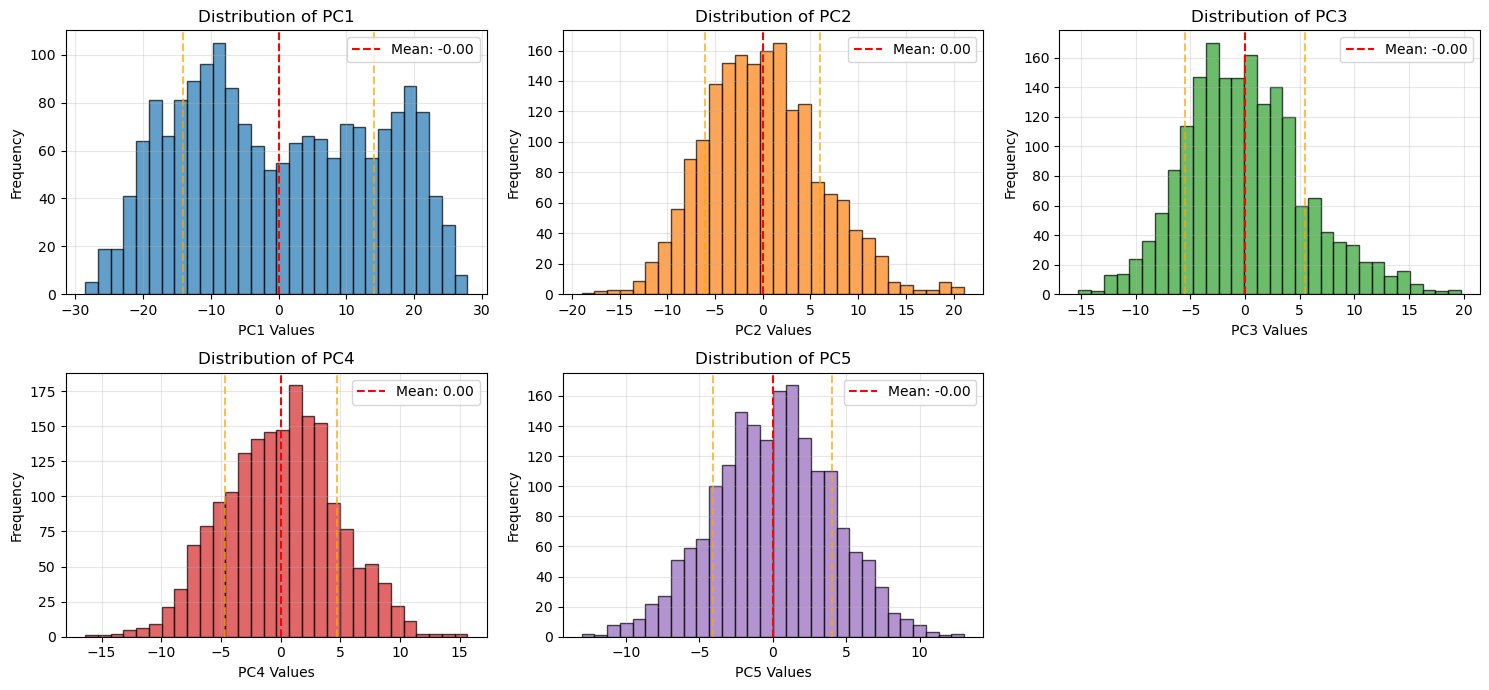


   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:
   • PC1: Mean=-0.000, Std=14.086, Min=-28.558, Max=27.864
   • PC2: Mean=0.000, Std=6.021, Min=-18.971, Max=21.115
   • PC3: Mean=-0.000, Std=5.528, Min=-15.231, Max=19.737
   • PC4: Mean=0.000, Std=4.695, Min=-16.390, Max=15.662
   • PC5: Mean=-0.000, Std=4.053, Min=-13.009, Max=13.021


In [15]:
# 3. HISTOGRAMS of first 5 components
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i in range(5):
    axes[i].hist(X_pca[:, i], bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_xlabel(f'PC{i+1} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = X_pca[:, i].mean()
    std_val = X_pca[:, i].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', 
                   label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.7)
    axes[i].legend()

axes[5].remove()

plt.tight_layout()
plt.show()

# 4. SUMMARY STATISTICS
print("\n   • SUMMARY STATISTICS FOR FIRST 5 COMPONENTS:")
for i in range(5):
    pc_data = X_pca[:, i]
    print(f"   • PC{i+1}: Mean={pc_data.mean():.3f}, Std={pc_data.std():.3f}, "
          f"Min={pc_data.min():.3f}, Max={pc_data.max():.3f}")


**PC2, PC3, PC4, PC5** → Normal distributions centered at 0, as expected in normalized PCA. These components show typical Gaussian-like behavior with:
- Mean ≈ 0 
- Symmetric, bell-shaped distributions
- Standard deviations around 1, indicating proper normalization

**PC1** → **Bimodal distribution**   
The bimodal pattern indicates that PC1 effectively separates the data into **two distinct groups**. This suggests:
- Two dominant meteorological regimes in European weather patterns
- PC1 captures the primary mode of atmospheric variability that distinguishes between these regimes
- Strong evidence for natural clustering structure in the data

<span style="color: skyblue;">VEDERE SE POSSO PLOTTARE QUESTE MAPPE CON I VALORI NONNORMALIZZATI MA ASSOLUTI DELLE LINEE (ritornare ai valori veri)</span> --> fatto sotto

<span style="color: skyblue;">SISTEMARE I GRAFICI AGGIUNGENDO LA MAPPA DELL'EUROPA - SHAPE, CODICE FRANCESCO</span>

VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI


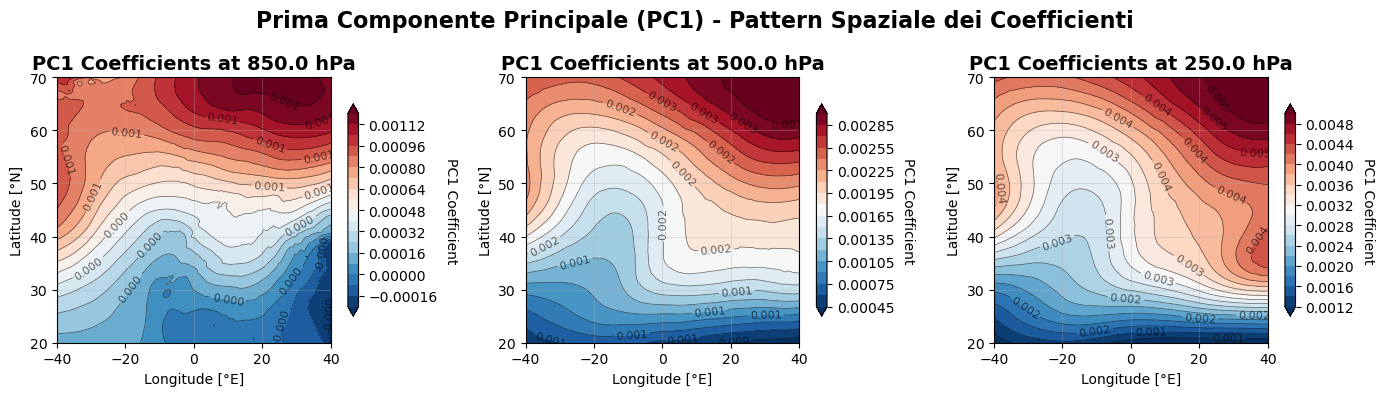

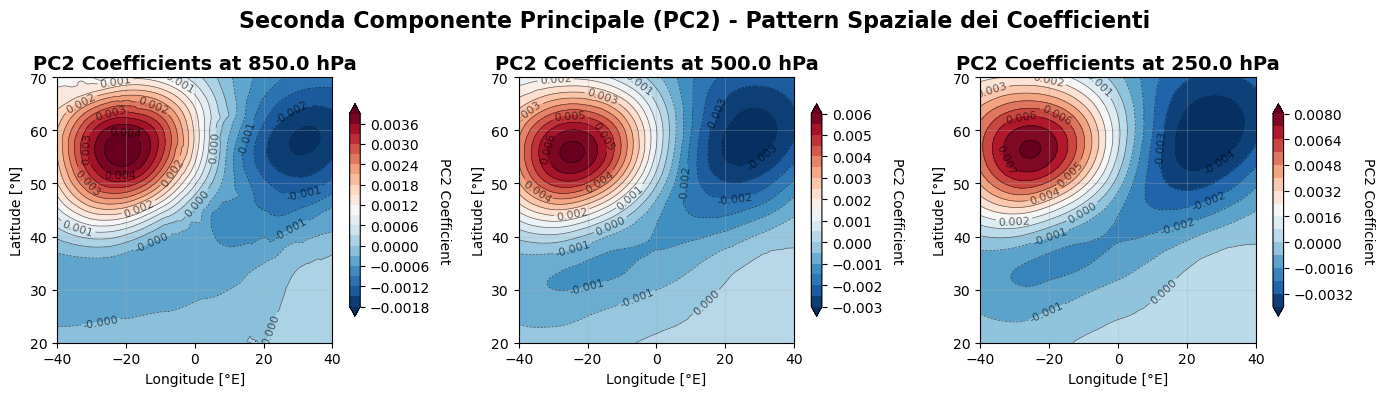

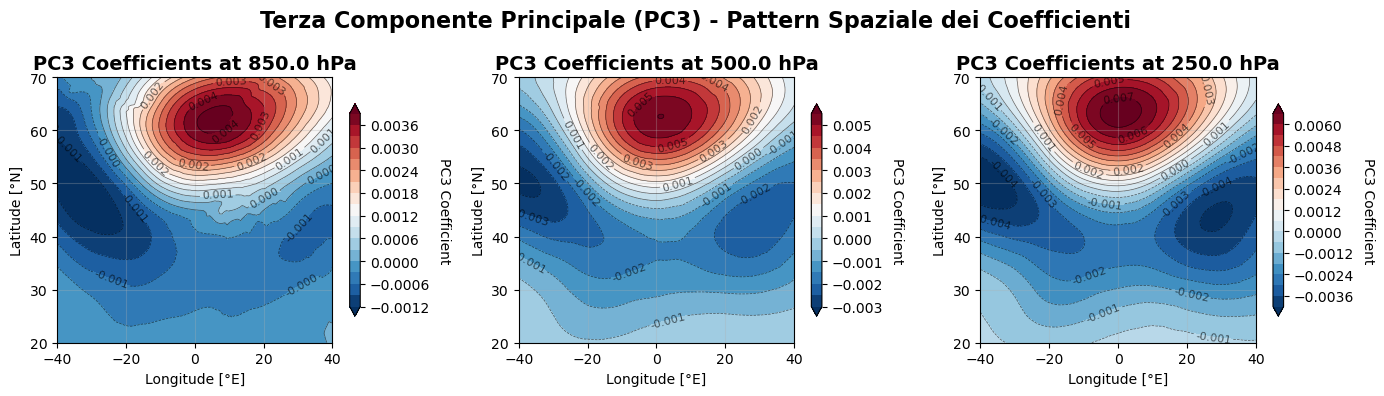


   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:
   • Pressure   PC1 Min      PC1 Max      PC2 Min      PC2 Max      PC3 Min      PC3 Max     
   • ------------------------------------------------------------------------------------
   • 850.0      -0.000273    0.001246     -0.001859    0.004138     -0.001457    0.004020    
   • 500.0      0.000369     0.003115     -0.003314    0.006164     -0.003116    0.005506    
   • 250.0      0.001035     0.005185     -0.004708    0.008148     -0.004695    0.006929    


In [16]:
print("VISUALIZZAZIONE DELLA PRIME COMPONENTI PRINCIPALI")

components_to_plot = [
    (ipca.components_[0], "PC1", "Prima Componente Principale (PC1)"),
    (ipca.components_[1], "PC2", "Seconda Componente Principale (PC2)"),
    (ipca.components_[2], "PC3", "Terza Componente Principale (PC3)")
]

# Get dimensions from original dataset (ds), not from X_pca which is a numpy array
n_lat = ds.dims['latitude'] if 'latitude' in ds.dims else len(ds.latitude)
n_lon = ds.dims['longitude'] if 'longitude' in ds.dims else len(ds.longitude)
n_pressure = ds.dims['isobaricInhPa'] if 'isobaricInhPa' in ds.dims else len(ds.isobaricInhPa)

lats = ds.latitude.values
lons = ds.longitude.values
pressure_levels = ds.isobaricInhPa.values.tolist()


for pc_coefficients, pc_name, pc_title in components_to_plot:
    
    # Forma originale dei coefficienti
    pc_reshaped = pc_coefficients.reshape(n_pressure, n_lat, n_lon)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    for i, (pressure, ax) in enumerate(zip(pressure_levels, axes)):
        # Dati per questo livello di pressione
        pc_level = pc_reshaped[i, :, :]
        
        # Coordinate per la mappa
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        # Contour plot
        contour_lines = ax.contour(lon_grid, lat_grid, pc_level, 
                                  levels=20, linewidths=0.5, colors='black', alpha=0.6)
        
        # Contour filled
        contour_filled = ax.contourf(lon_grid, lat_grid, pc_level, 
                                    levels=20, cmap="RdBu_r", extend='both')
        
        # Etichette delle isolinee
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
        
        ax.set_title(f'{pc_name} Coefficients at {pressure} hPa', fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
        cbar.set_label(f'{pc_name} Coefficient', rotation=270, labelpad=15)
    
    # Titolo generale
    fig.suptitle(f'{pc_title} - Pattern Spaziale dei Coefficienti', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Statistiche comparative per tutte le componenti
print(f"\n   • STATISTICHE COMPARATIVE PER LIVELLO DI PRESSIONE:")
print(f"   • {'Pressure':<10} {'PC1 Min':<12} {'PC1 Max':<12} {'PC2 Min':<12} {'PC2 Max':<12} {'PC3 Min':<12} {'PC3 Max':<12}")
print(f"   • {'-'*84}")

# Ricostruisci tutte le componenti per le statistiche
pc1_reshaped = components_to_plot[0][0].reshape(n_pressure, n_lat, n_lon)
pc2_reshaped = components_to_plot[1][0].reshape(n_pressure, n_lat, n_lon)
pc3_reshaped = components_to_plot[2][0].reshape(n_pressure, n_lat, n_lon)

for i, pressure in enumerate(pressure_levels):
    pc1_level = pc1_reshaped[i, :, :]
    pc2_level = pc2_reshaped[i, :, :]
    pc3_level = pc3_reshaped[i, :, :]
    
    print(f"   • {pressure:<10} {pc1_level.min():<12.6f} {pc1_level.max():<12.6f} "
          f"{pc2_level.min():<12.6f} {pc2_level.max():<12.6f} "
          f"{pc3_level.min():<12.6f} {pc3_level.max():<12.6f}")

The previous plots represent the spatial distribution of the pca coefficients but those coefficients are abstract and cannot be intrepreted physically. So here we plot the real atmospheric pattern that every single principal component represents.

VISUALIZZAZIONE DEI PATTERN ATMOSFERICI REALI DELLE COMPONENTI PRINCIPALI

=== Prima Componente Principale (PC1) ===
Giorno con PC1 massimo: 1294 (score: 27.864)
Giorno con PC1 minimo: 1129 (score: -28.558)


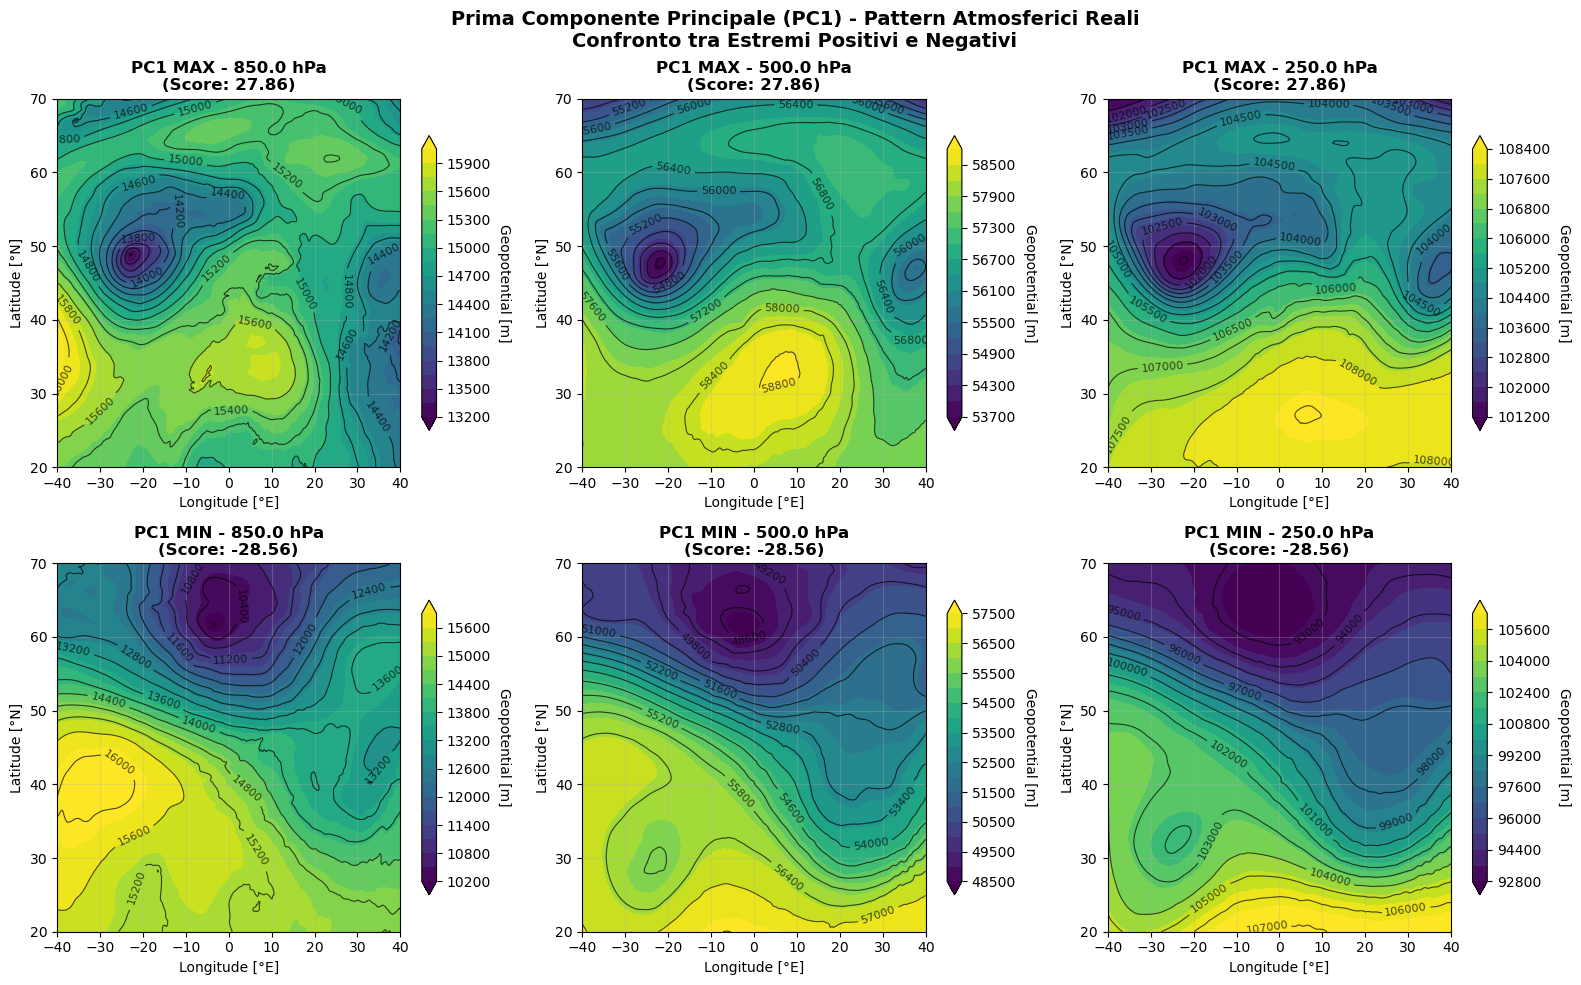

Statistiche geopotenziale per PC1:
  850.0 hPa - MAX: 15041±453m
  850.0 hPa - MIN: 13827±1565m
  850.0 hPa - DIFF: 1214m
  500.0 hPa - MAX: 57058±1038m
  500.0 hPa - MIN: 53507±2746m
  500.0 hPa - DIFF: 3552m
  250.0 hPa - MAX: 105687±1887m
  250.0 hPa - MIN: 99335±4285m
  250.0 hPa - DIFF: 6353m

=== Seconda Componente Principale (PC2) ===
Giorno con PC2 massimo: 22 (score: 21.115)
Giorno con PC2 minimo: 763 (score: -18.971)


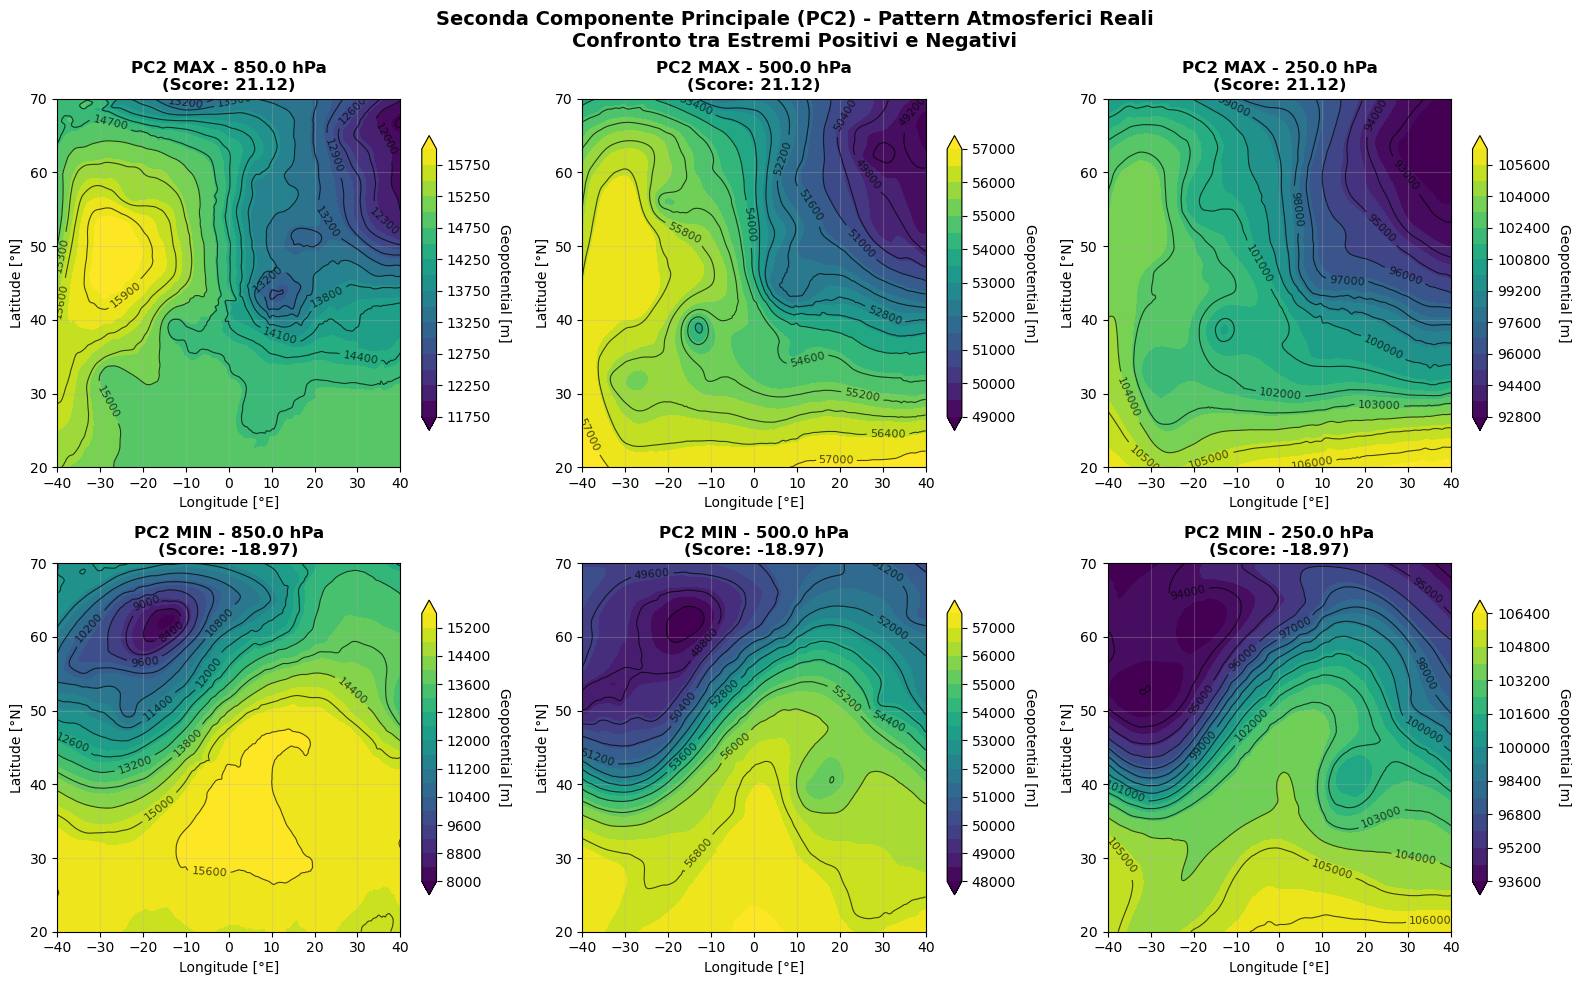

Statistiche geopotenziale per PC2:
  850.0 hPa - MAX: 14479±957m
  850.0 hPa - MIN: 13768±2007m
  850.0 hPa - DIFF: 710m
  500.0 hPa - MAX: 54284±2236m
  500.0 hPa - MIN: 53939±3047m
  500.0 hPa - DIFF: 345m
  250.0 hPa - MAX: 100378±3586m
  250.0 hPa - MIN: 100384±4206m
  250.0 hPa - DIFF: -6m

=== Terza Componente Principale (PC3) ===
Giorno con PC3 massimo: 713 (score: 19.737)
Giorno con PC3 minimo: 784 (score: -15.231)


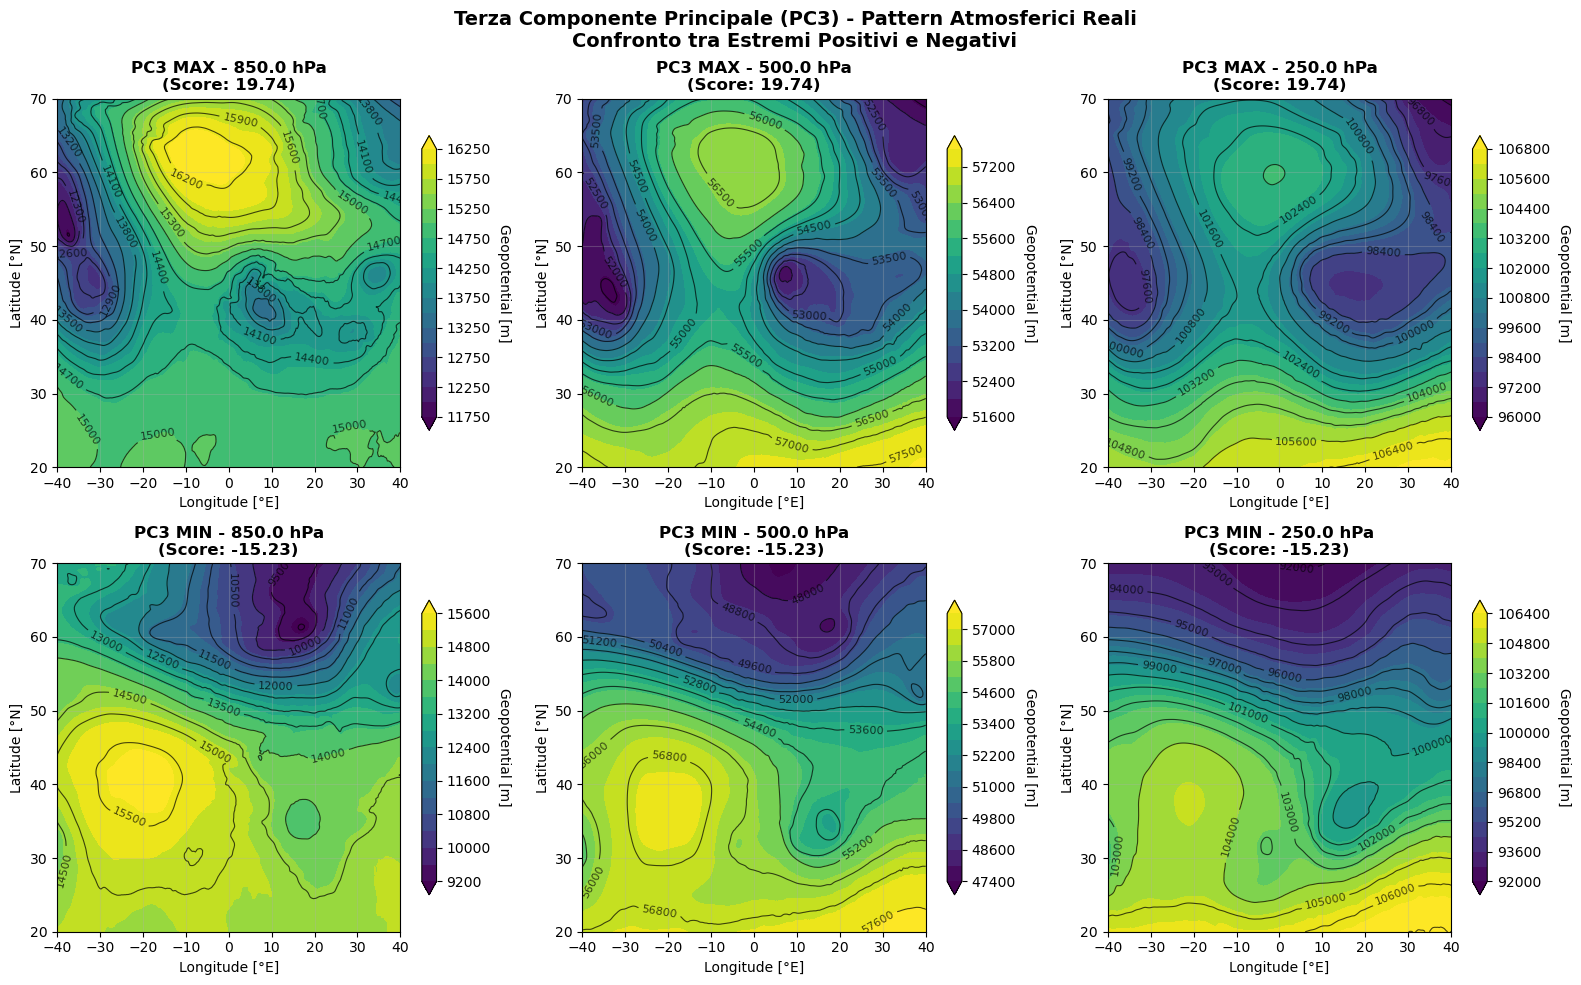

Statistiche geopotenziale per PC3:
  850.0 hPa - MAX: 14683±828m
  850.0 hPa - MIN: 13612±1688m
  850.0 hPa - DIFF: 1071m
  500.0 hPa - MAX: 54934±1489m
  500.0 hPa - MIN: 53614±3059m
  500.0 hPa - DIFF: 1320m
  250.0 hPa - MAX: 101418±2457m
  250.0 hPa - MIN: 100170±4325m
  250.0 hPa - DIFF: 1248m


In [22]:
print("VISUALIZZAZIONE DEI PATTERN ATMOSFERICI REALI DELLE COMPONENTI PRINCIPALI")

# NUOVO: Ricostruisci i pattern atmosferici originali
# Per ogni componente principale, calcola cosa rappresenta in termini di geopotenziale

for pc_idx, (pc_coefficients, pc_name, pc_title) in enumerate(components_to_plot):
    
    print(f"\n=== {pc_title} ===")
    
    # Prendi alcuni campioni estremi per questa componente
    pc_scores = X_pca[:, pc_idx]  # Scores di tutti i campioni per questa PC
    
    # Trova i giorni con valori estremi (positivi e negativi) per questa PC
    extreme_positive_idx = np.argmax(pc_scores)  # Giorno con valore PC più alto
    extreme_negative_idx = np.argmin(pc_scores)  # Giorno con valore PC più basso
    
    print(f"Giorno con {pc_name} massimo: {extreme_positive_idx} (score: {pc_scores[extreme_positive_idx]:.3f})")
    print(f"Giorno con {pc_name} minimo: {extreme_negative_idx} (score: {pc_scores[extreme_negative_idx]:.3f})")
    
    # Estrai i dati originali (de-standardizzati) per questi giorni
    # IMPORTANTE: devi ricostruire i valori originali dal dataset
    original_data_positive = ds.z.isel(time=extreme_positive_idx)  # Dati originali giorno "positivo"
    original_data_negative = ds.z.isel(time=extreme_negative_idx)  # Dati originali giorno "negativo"
    
    # Crea subplots per confrontare i due estremi
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Plot per extreme positive
    for i, pressure in enumerate(pressure_levels):
        ax = axes[0, i]
        data_positive = original_data_positive.sel(isobaricInhPa=pressure)
        
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        # Contour lines
        contour_lines = ax.contour(lon_grid, lat_grid, data_positive, 
                                  levels=15, linewidths=0.8, colors='black', alpha=0.7)
        
        # Contour filled  
        contour_filled = ax.contourf(lon_grid, lat_grid, data_positive, 
                                    levels=20, cmap="viridis", extend='both')
        
        # Labels on contour lines
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%d')
        
        ax.set_title(f'{pc_name} MAX - {pressure} hPa\n(Score: {pc_scores[extreme_positive_idx]:.2f})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
        cbar.set_label('Geopotential [m]', rotation=270, labelpad=15)
    
    # Plot per extreme negative  
    for i, pressure in enumerate(pressure_levels):
        ax = axes[1, i]
        data_negative = original_data_negative.sel(isobaricInhPa=pressure)
        
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        # Contour lines
        contour_lines = ax.contour(lon_grid, lat_grid, data_negative, 
                                  levels=15, linewidths=0.8, colors='black', alpha=0.7)
        
        # Contour filled
        contour_filled = ax.contourf(lon_grid, lat_grid, data_negative, 
                                    levels=20, cmap="viridis", extend='both')
        
        # Labels on contour lines
        ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%d')
        
        ax.set_title(f'{pc_name} MIN - {pressure} hPa\n(Score: {pc_scores[extreme_negative_idx]:.2f})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.8)
        cbar.set_label('Geopotential [m]', rotation=270, labelpad=15)
    
    # Titolo generale
    fig.suptitle(f'{pc_title} - Pattern Atmosferici Reali\nConfronto tra Estremi Positivi e Negativi', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Stampa statistiche sui pattern
    print(f"Statistiche geopotenziale per {pc_name}:")
    for pressure in pressure_levels:
        pos_data = original_data_positive.sel(isobaricInhPa=pressure)
        neg_data = original_data_negative.sel(isobaricInhPa=pressure)
        
        print(f"  {pressure} hPa - MAX: {pos_data.mean().values:.0f}±{pos_data.std().values:.0f}m")
        print(f"  {pressure} hPa - MIN: {neg_data.mean().values:.0f}±{neg_data.std().values:.0f}m")
        print(f"  {pressure} hPa - DIFF: {(pos_data.mean() - neg_data.mean()).values:.0f}m")

**Prima Componente Principale (PC1) - 42.8% della varianza**
Pattern identificato: GRADIENTE NORD-SUD EUROPEO

PC1 Positivo (MAX): Configurazione con alta pressione al sud e bassa al nord

Anticiclone prominente sull'Europa meridionale/Mediterraneo  
Depressione ciclonica sulla Scandinavia  
Forte gradiente barico nord-sud (differenza di 1214m a 850 hPa)  
PC1 Negativo (MIN): Configurazione opposta

Alta pressione estesa verso nord  
Pattern più omogeneo su tutta l'Europa  
Rappresenta condizioni più stabili e uniformi

**Seconda Componente Principale (PC2) - 27.6% della varianza**  
Pattern identificato: GRADIENTE OVEST-EST

PC2 Positivo (MAX): Alta pressione a ovest, bassa a est

Anticiclone atlantico che si estende verso l'Europa occidentale  
Valori di geopotenziale più bassi verso est  
Pattern tipico dell'influenza atlantica  
PC2 Negativo (MIN): Inversione del gradiente ovest-est

Configurazione con influenza continentale più marcata  
Differenze minori tra livelli (solo 345m a 500 hPa)  

**Terza Componente Principale (PC3) - 14.8% della varianza**  
Pattern identificato: PATTERN DIPOLARI COMPLESSI    

PC3 Positivo (MAX): Strutture dipolari ben definite

Alternanza di centri di alta e bassa pressione  
Pattern più localizzati e complessi  
PC3 Negativo (MIN): Configurazioni più zonali  

Pattern più estesi longitudinalmente  
Strutture meno localizzate  
🔍 OSSERVAZIONI CHIAVE  
Coerenza Verticale: I pattern sono coerenti attraverso tutti i livelli atmosferici (850, 500, 250 hPa),   indicando strutture barotropiche profonde

Intensità del Segnale: PC1 mostra le differenze più marcate (6353m a 250 hPa), confermando che è il modo dominante di variabilità

Significato Meteorologico:

PC1 rappresenta l'oscillazione principale dell'Europa tra configurazioni meridionali e settentrionali  
PC2 cattura l'influenza atlantica vs continentale  
PC3 descrive pattern più complessi e localizzati

_ _ _ - - _ _ _ - - _ _ _ 

We chose **not to weight the principal components** by their explained variance for the clustering analysis. While PC1 dominates with 54.2% of the variance compared to PC2 (9.9%) and PC3 (8.3%), weighting schemes significantly compromise the clustering quality. Linear weighting causes PC1 to dominate 97.5% of the clustering influence, effectively reducing the problem to a unidimensional analysis and eliminating the contribution of meteorologically meaningful secondary patterns.   
Even moderate $\sqrt{variance}$ weighting biases the clustering toward PC1 (84% influence) while drastically reducing the impact of PC2 and PC3. In contrast, unweighted components maintain a balanced contribution, preserving the multidimensional structure of atmospheric variability.   
This approach is particularly important for meteorological applications where secondary components often capture crucial regional patterns, seasonal variations, or synoptic-scale features that, despite explaining less variance globally, are essential for identifying distinct weather regimes. 

## 3 Clusterization /o classification?


Now that we have analyzed the data, we have performed Principal Component Analysis (PCA) in order to reduce the dimensionality of the dataset and to highlight the most relevant features and components.
The next step is to implement an algorithm to cluster the data. The first method we will apply is the k-means algorithm.

_pg 28 articolo 2-the classification of atmosphere .._

### 3.1 K-means Implementation

The k-means algorithm allows us to divide the dataset into k groups (k is given, and we will perform an analysis later to determine the best value, as this is a key point). The association of each element in the dataset to a specific group is based on its attributes.

_it is a top-down procedure_

The goal of the algorithm is to minimize the total variance between different groups. Each group is identified through a centroid, note that they are not, in general, points from the dataset although they live in the same space.

Iteratively, the algorithm creates k partitions and assigns the incoming points to the groups. Then, it computes the centroids of each cluster and reassigns each point to the nearest centroid, using the Euclidean distance or another metric. The new centroids are then computed again, and the process continues until the method converges.

<span style="color: orange;">The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. </span>

_per me_  
**INIZIALIZZAZIONE**: k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.  
‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.
If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.  
If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.  

**N_INIT** : Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended for sparse high-dimensional problems

-  -  

Perché k-means++ è preferibile:

    Sceglie il primo centro a caso, poi ogni centro successivo è scelto con probabilità proporzionale alla distanza al quadrato dal centro più vicino → evita centri troppo vicini fra loro.  
    Riduce la probabilità di convergere a soluzioni pessime.  
    Richiede poco overhead computazionale rispetto a una scelta casuale pura.

_fit(X, y=None, sample_weight=None)_ --> computes k-means clustering. ----  _returns:_ Fitted estimator.

_fit_predict(X, y=None, sample_weight=None)_ --> Compute cluster centers and predict cluster index for each sample. --- _returns:_ Index of the cluster each sample belongs to.

_predict(X)_ --> Predict the closest cluster each sample in X belongs to. ---  _returns:_ Index of the cluster each sample belongs to.

_transform(X)_ --> Transform X to a cluster-distance space. In the new space, each dimension is the distance to the cluster centers. Note that even if X is sparse, the array returned by transform will typically be dense --- _returns:_ X transformed in the new space.

<span style="color: skyblue;">implementare bene e corregggere il kmeans con più valori di k</span>

Dataset shape : (1827, 30)
Cluster counts(n° of points per cluster): [861 966]
Labels shape: (1827,)
Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Centroids shape: (2, 30)
Centroids: [[ 1.30822107e+01 -1.20845112e-01 -4.13734816e-01  8.73809004e-03
  -3.60266700e-01 -1.18187006e-01  1.13581206e-02  3.30615050e-02
  -2.55508986e-02 -1.59199120e-02 -4.50003157e-03  3.02895442e-03
  -1.62858798e-02  4.79565124e-02  5.02822742e-02 -9.68744983e-03
  -2.47670717e-02  3.77391722e-03  1.01273003e-02 -4.32652362e-03
  -2.25432370e-03 -1.65247139e-02 -3.02898913e-03 -1.79851059e-02
   1.02218623e-02 -2.20557420e-02 -1.55181371e-02  1.38207863e-02
  -1.11923850e-03  1.92972857e-02]
 [-1.16602312e+01  1.07709773e-01  3.68763640e-01 -7.78829764e-03
   3.21107276e-01  1.05340592e-01 -1.01235423e-02 -2.94678631e-02
   2.27736270e-02  1.4

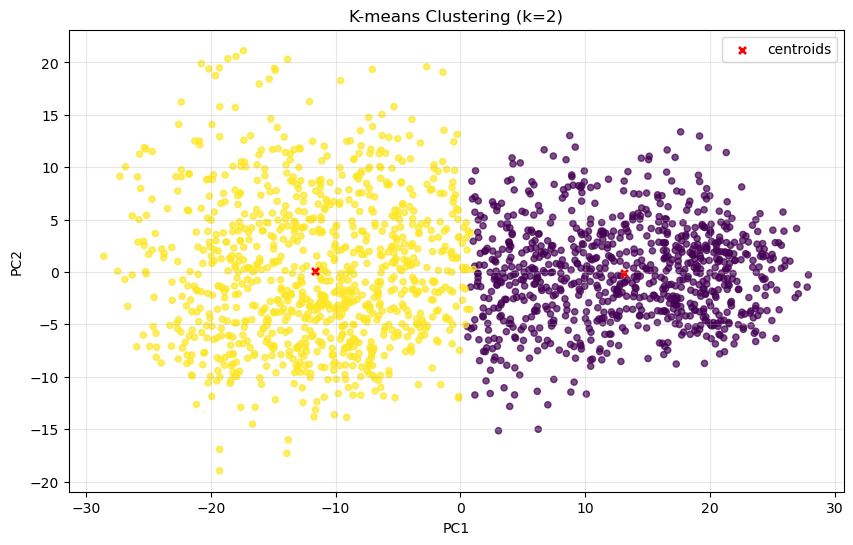

Cluster 0: 861 samples (47.1%)
Cluster 1: 966 samples (52.9%)


In [17]:
print(f"Dataset shape : {X_pca.shape}")

# Choose k 
k = 2

# Create kmeans model
random_state = 123
n_init = 15
max_iter = 300
kmeans = KMeans(n_clusters=k, random_state=random_state,init='k-means++', n_init=n_init, max_iter=max_iter)


# Train the model
kmeans.fit(X_pca)  # executes the algorithm

labels = kmeans.labels_
print(f"Cluster counts(n° of points per cluster): {np.bincount(labels)}")
print(f"Labels shape: {labels.shape}")
print(f"Labels: {labels[:100]}")  


# Compute the centroids
centroids= kmeans.cluster_centers_ 
print(f"Centroids shape: {centroids.shape}")
print(f"Centroids: {centroids[:k]}")

# Compute the inertia -> sum of the distances to the square
inertia = kmeans.inertia_   
print(f"Inertia (lower is better): {inertia:.2f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:,0], X_pca[:,1], c= labels, cmap='viridis', alpha = 0.7, s=20) 
plt.scatter(centroids[:,0], centroids[:,1], c= 'red', marker='x', s= 25, linewidths= 2, label= 'centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f"K-means Clustering (k={k})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


for i in range(k):
    cluster_size = np.sum(labels == i)
    print(f"Cluster {i}: {cluster_size} samples ({cluster_size/len(labels)*100:.1f}%)")

Il grafico mostra una separazione netta lungo PC1  
I due cluster sono chiaramente distinti  
I centroidi (X rosse) sono ben posizionati al centro di ogni cluster  
Osservazioni chiave:  
PC1 è il discriminante principale (come previsto dalla bimodalità)  
PC2 mostra variabilità interna ai cluster (normale)

<span style="color: skyblue;">**STAMPO I VETTORI DEI CENTROIDI + KMEANS CON PIù K + CAPIRE SE DIVIDIERE IL DATASET IN TRAIN E TEST**</span>

In [18]:
print("ANALISI K-MEANS CON DIVERSI VALORI DI K")

# Range di k da testare
k_range = range(2, 20)  # k = 2, 3, 4, 5, 6, 7
print(f"   • Testing k values: {list(k_range)}")

# Dizionari per salvare i risultati
results = {
    'k_values': [],
    'inertias': [],
    'labels_dict': {},
    'centroids_dict': {},
    'models_dict': {}
}

print(f"   • Dataset shape: {X_pca.shape}")
print(f"\n   • Running K-means for different k values...")

# Loop su diversi valori di k
for k in k_range:
    print(f"\n   → K = {k}")
    
    # Crea e addestra il modello
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10, max_iter=300)
    kmeans.fit(X_pca)
    
    # Salva i risultati
    results['k_values'].append(k)
    results['inertias'].append(kmeans.inertia_)
    results['labels_dict'][k] = kmeans.labels_
    results['centroids_dict'][k] = kmeans.cluster_centers_
    results['models_dict'][k] = kmeans
    
    # Statistiche per questo k
    cluster_counts = np.bincount(kmeans.labels_)
    print(f"     • Inertia: {kmeans.inertia_:,.2f}")
    print(f"     • Cluster sizes: {cluster_counts}")
    
    # Percentuali
    percentages = [f"{size/len(kmeans.labels_)*100:.1f}%" for size in cluster_counts]
    print(f"     • Cluster percentages: {percentages}")

print(f"\n✅ Completato! Risultati salvati nel dizionario 'results'")
print(f"   • Inerzie: {[f'{x:,.0f}' for x in results['inertias']]}")

ANALISI K-MEANS CON DIVERSI VALORI DI K
   • Testing k values: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
   • Dataset shape: (1827, 30)

   • Running K-means for different k values...

   → K = 2
     • Inertia: 374,696.58
     • Cluster sizes: [861 966]
     • Cluster percentages: ['47.1%', '52.9%']

   → K = 3
     • Inertia: 329,202.73
     • Cluster sizes: [621 646 560]
     • Cluster percentages: ['34.0%', '35.4%', '30.7%']

   → K = 4
     • Inertia: 301,235.15
     • Cluster sizes: [457 579 472 319]
     • Cluster percentages: ['25.0%', '31.7%', '25.8%', '17.5%']

   → K = 5
     • Inertia: 329,202.73
     • Cluster sizes: [621 646 560]
     • Cluster percentages: ['34.0%', '35.4%', '30.7%']

   → K = 4
     • Inertia: 301,235.15
     • Cluster sizes: [457 579 472 319]
     • Cluster percentages: ['25.0%', '31.7%', '25.8%', '17.5%']

   → K = 5
     • Inertia: 281,763.46
     • Cluster sizes: [254 485 432 380 276]
     • Cluster percentages: ['13.9%', '26.

VISUALIZZAZIONE DEI RISULTATI - ANALISI DEL GOMITO


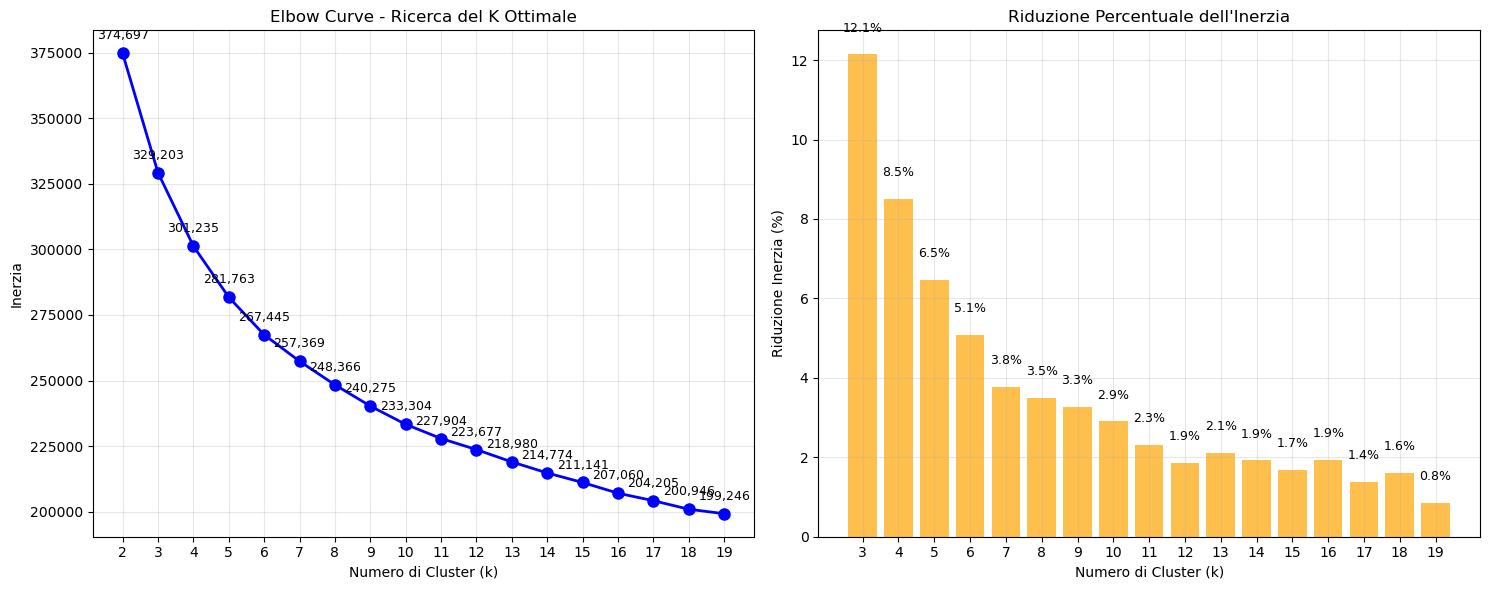


📊 TABELLA RIASSUNTIVA:
K   Inerzia         Riduzione %  Valutazione    
--------------------------------------------------
2   374,697         -            Baseline       
3   329,203         12.1%        Moderata       
4   301,235         8.5%         Moderata       
5   281,763         6.5%         Bassa riduzione
6   267,445         5.1%         Bassa riduzione
7   257,369         3.8%         Bassa riduzione
8   248,366         3.5%         Bassa riduzione
9   240,275         3.3%         Bassa riduzione
10  233,304         2.9%         Bassa riduzione
11  227,904         2.3%         Bassa riduzione
12  223,677         1.9%         Bassa riduzione
13  218,980         2.1%         Bassa riduzione
14  214,774         1.9%         Bassa riduzione
15  211,141         1.7%         Bassa riduzione
16  207,060         1.9%         Bassa riduzione
17  204,205         1.4%         Bassa riduzione
18  200,946         1.6%         Bassa riduzione
19  199,246         0.8%         Bassa ridu

In [19]:
print("VISUALIZZAZIONE DEI RISULTATI - ANALISI DEL GOMITO")

# 1. GRAFICO DELL'INERZIA (ELBOW CURVE)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow curve
ax1.plot(results['k_values'], results['inertias'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Numero di Cluster (k)')
ax1.set_ylabel('Inerzia')
ax1.set_title('Elbow Curve - Ricerca del K Ottimale')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(results['k_values'])

# Aggiungi valori sull'asse
for i, (k, inertia) in enumerate(zip(results['k_values'], results['inertias'])):
    ax1.annotate(f'{inertia:,.0f}', 
                (k, inertia), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=9)

# 2. RIDUZIONE PERCENTUALE DELL'INERZIA
inertia_reductions = []
for i in range(1, len(results['inertias'])):
    reduction = (results['inertias'][i-1] - results['inertias'][i]) / results['inertias'][i-1] * 100
    inertia_reductions.append(reduction)

ax2.bar(results['k_values'][1:], inertia_reductions, alpha=0.7, color='orange')
ax2.set_xlabel('Numero di Cluster (k)')
ax2.set_ylabel('Riduzione Inerzia (%)')
ax2.set_title('Riduzione Percentuale dell\'Inerzia')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(results['k_values'][1:])

# Aggiungi valori sulle barre
for i, (k, reduction) in enumerate(zip(results['k_values'][1:], inertia_reductions)):
    ax2.text(k, reduction + 0.5, f'{reduction:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 3. TABELLA RIASSUNTIVA
print(f"\n📊 TABELLA RIASSUNTIVA:")
print(f"{'K':<3} {'Inerzia':<15} {'Riduzione %':<12} {'Valutazione':<15}")
print(f"{'-'*50}")

for i, k in enumerate(results['k_values']):
    inertia_str = f"{results['inertias'][i]:,.0f}"
    
    if i == 0:
        reduction_str = "-"
        evaluation = "Baseline"
    else:
        reduction = inertia_reductions[i-1]
        reduction_str = f"{reduction:.1f}%"
        
        if reduction > 15:
            evaluation = "Buona riduzione"
        elif reduction > 8:
            evaluation = "Moderata"
        else:
            evaluation = "Bassa riduzione"
    
    print(f"{k:<3} {inertia_str:<15} {reduction_str:<12} {evaluation:<15}")

print(f"\n💡 INTERPRETAZIONE:")
print(f"   • Cerca il 'gomito' nella curva - punto dove la riduzione rallenta")
print(f"   • Valori di riduzione >10-15% indicano miglioramenti significativi")
print(f"   • Il k ottimale è solitamente dove la curva inizia a stabilizzarsi")

VISUALIZZAZIONE DEI CLUSTER PER DIVERSI K


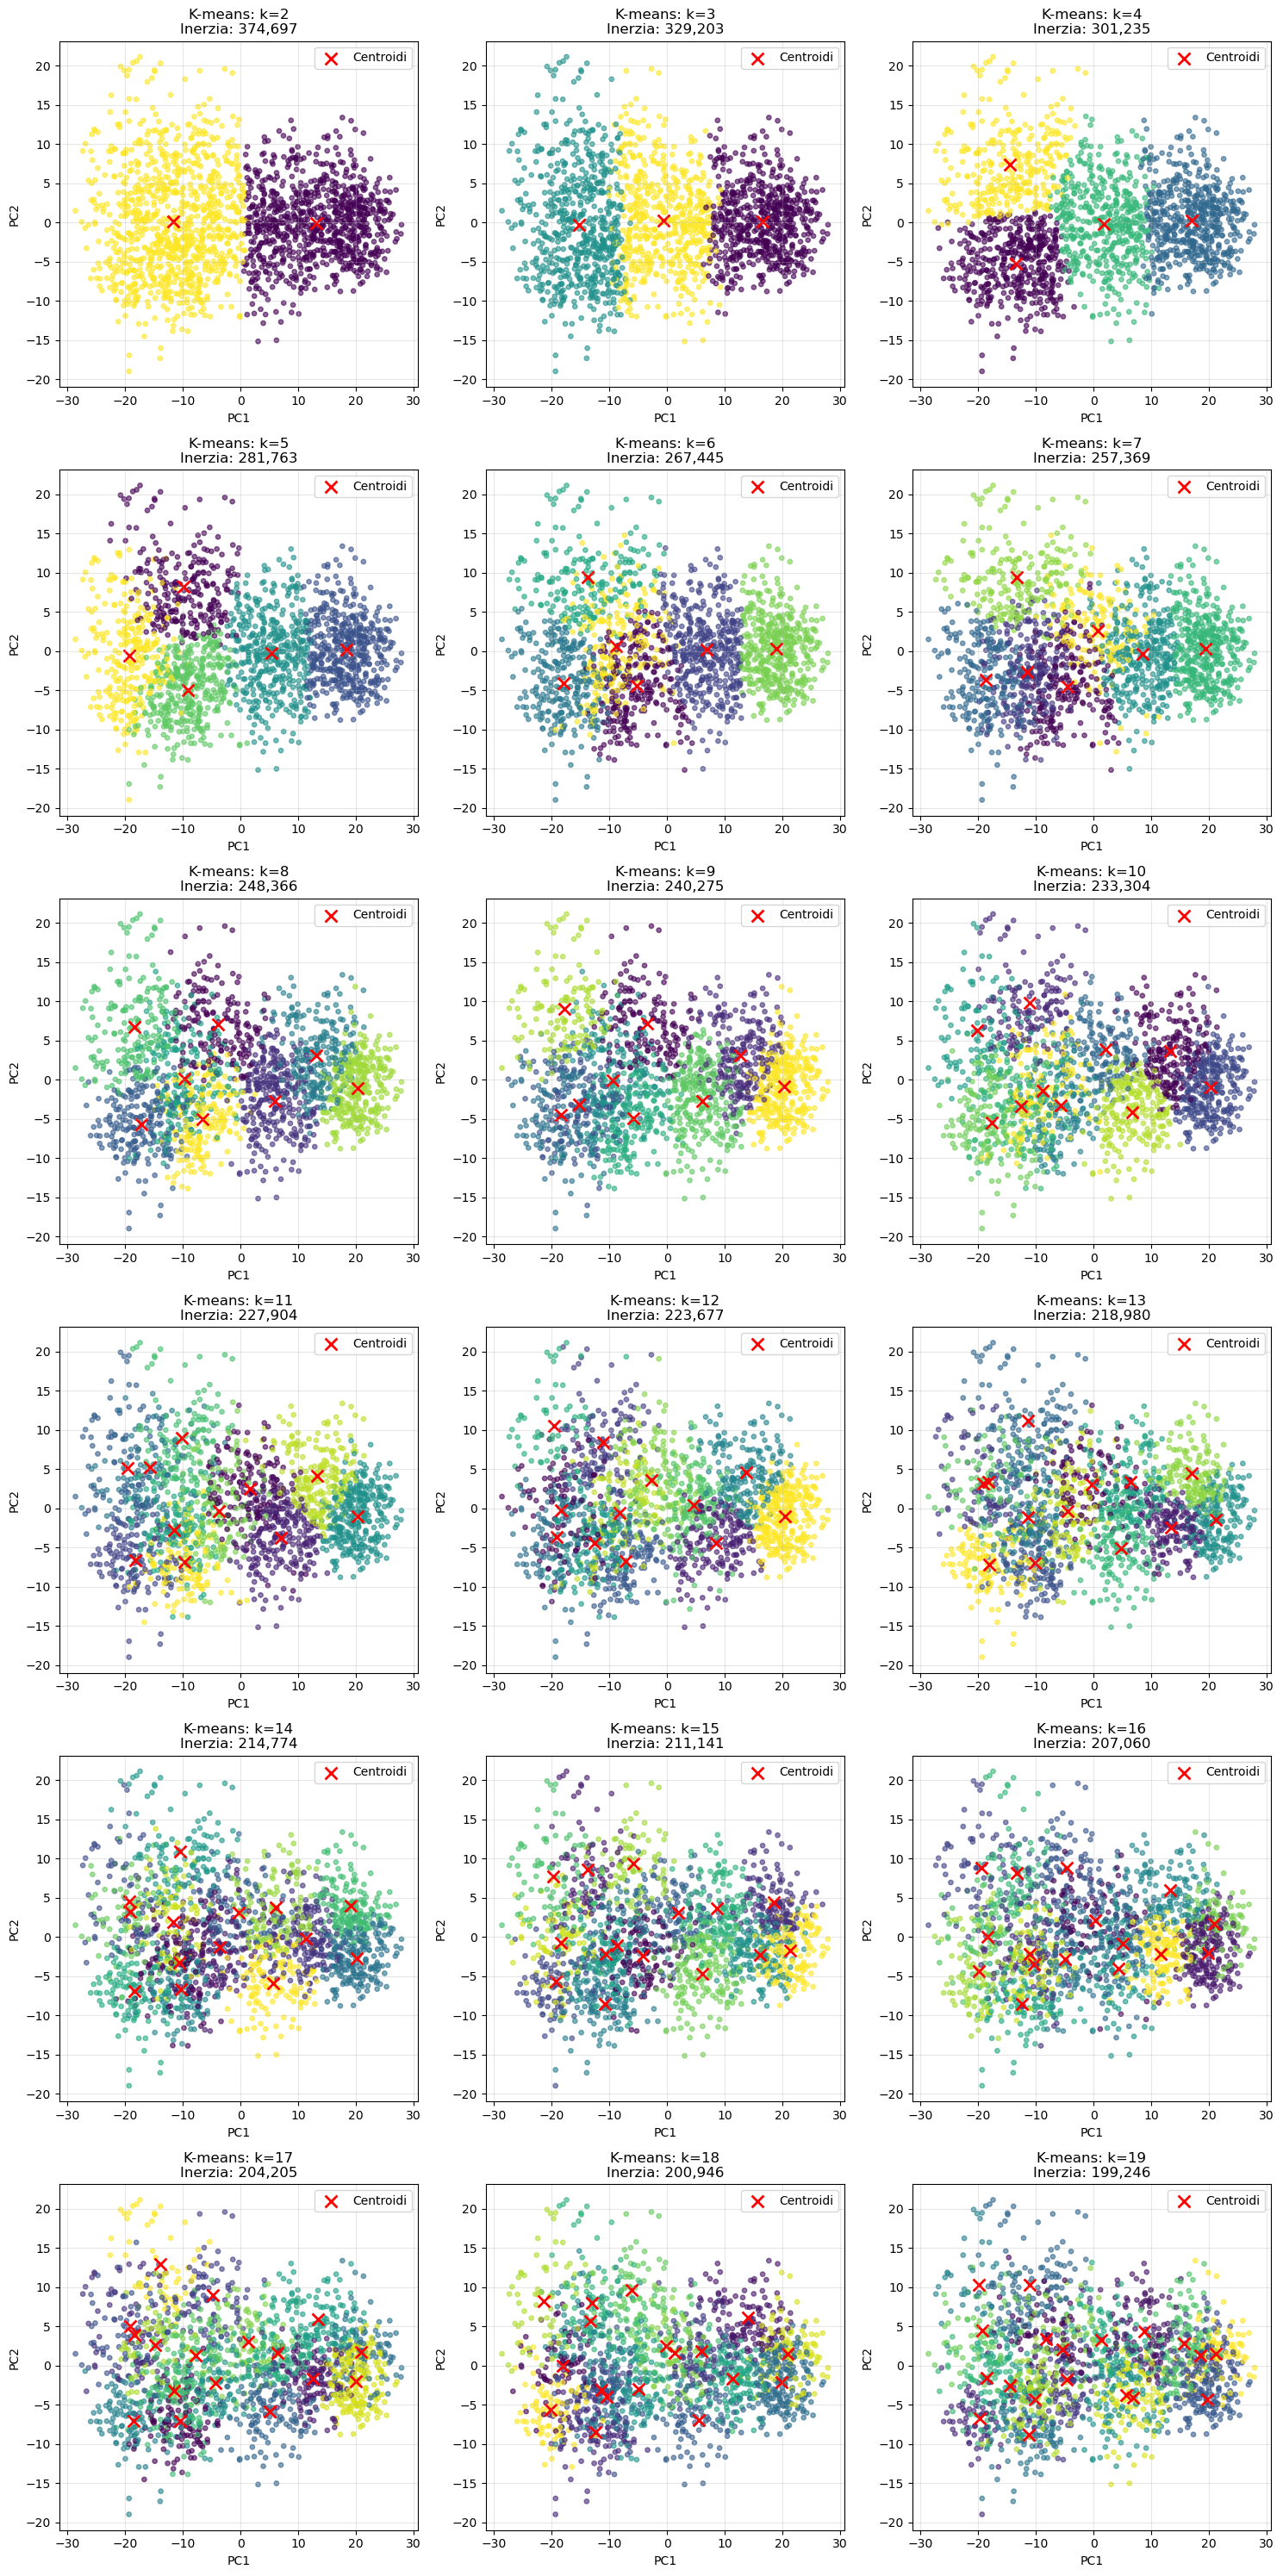


📈 ANALISI DELLE DIMENSIONI DEI CLUSTER:

   K = 2:
     Cluster 0:  861 campioni ( 47.1%)
     Cluster 1:  966 campioni ( 52.9%)
     Bilanciamento: 0.891 (1.0 = perfetto)

   K = 3:
     Cluster 0:  621 campioni ( 34.0%)
     Cluster 1:  646 campioni ( 35.4%)
     Cluster 2:  560 campioni ( 30.7%)
     Bilanciamento: 0.867 (1.0 = perfetto)

   K = 4:
     Cluster 0:  457 campioni ( 25.0%)
     Cluster 1:  579 campioni ( 31.7%)
     Cluster 2:  472 campioni ( 25.8%)
     Cluster 3:  319 campioni ( 17.5%)
     Bilanciamento: 0.551 (1.0 = perfetto)

   K = 5:
     Cluster 0:  254 campioni ( 13.9%)
     Cluster 1:  485 campioni ( 26.5%)
     Cluster 2:  432 campioni ( 23.6%)
     Cluster 3:  380 campioni ( 20.8%)
     Cluster 4:  276 campioni ( 15.1%)
     Bilanciamento: 0.524 (1.0 = perfetto)

   K = 6:
     Cluster 0:  255 campioni ( 14.0%)
     Cluster 1:  416 campioni ( 22.8%)
     Cluster 2:  282 campioni ( 15.4%)
     Cluster 3:  204 campioni ( 11.2%)
     Cluster 4:  440 campioni 

In [20]:
print("VISUALIZZAZIONE DEI CLUSTER PER DIVERSI K")

# Crea subplot per visualizzare cluster con diversi k
n_plots = len(results['k_values'])
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, k in enumerate(results['k_values']):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    
    # Plot dei punti colorati per cluster
    labels = results['labels_dict'][k]
    centroids = results['centroids_dict'][k]
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, s=15)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, linewidths=2, label='Centroidi')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'K-means: k={k}\nInerzia: {results["inertias"][i]:,.0f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Rimuovi subplot vuoti se necessario
for i in range(n_plots, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].remove()

plt.tight_layout()
plt.show()

# Analisi delle dimensioni dei cluster
print(f"\n📈 ANALISI DELLE DIMENSIONI DEI CLUSTER:")
for k in results['k_values']:
    labels = results['labels_dict'][k]
    cluster_counts = np.bincount(labels)
    percentages = [count/len(labels)*100 for count in cluster_counts]
    
    print(f"\n   K = {k}:")
    for i, (count, perc) in enumerate(zip(cluster_counts, percentages)):
        print(f"     Cluster {i}: {count:4d} campioni ({perc:5.1f}%)")
    
    # Calcola bilanciamento
    min_perc = min(percentages)
    max_perc = max(percentages)
    balance = min_perc / max_perc
    print(f"     Bilanciamento: {balance:.3f} (1.0 = perfetto)")

#### 3.1.1 Evaluation of the best number of clusters (k)

_PER SELEZIONARE IL NUMERO DI CLUSTERS_ -->  https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py  

. curva a gomito  
. pg.519 - BookAdvanced

_ _ _ - - _ _ _ 

Idea intuitiva: se ci sono davvero K* gruppi naturali, aumentando K da 1 fino a K* ogni incremento separa veri gruppi e provoca una grande riduzione di WKWK​. Per K>K* ogni ulteriore cluster tende a spezzare gruppi già omogenei → riduzioni piccole. Quindi il grafico K vs W_k_ha una curva decrescente con un kink (gomito) approssimativamente a K*

WK(inertia)​ è la somma delle varianze interne (o somme di distanze quadratiche) di tutti i cluster.

WK​ è proprio la misura totale di “quanto sono vicini” i punti ai loro centri di cluster.

    Se i punti sono molto vicini al centro → W_k​ sarà piccolo (buon clustering).

    Se i punti sono sparsi → W_k_sarà grande.

Quando aumenti K (cioè il numero di cluster), i punti possono essere raggruppati in insiemi più piccoli e più vicini ai loro centri → WKWK​ tende sempre a diminuire

_ _ _ - - _ _ _ - - _ _ _


#### 💡 Suggerimenti Extra per il K-means

**🔧 Se hai problemi, ecco alcuni tips:**

3. **Risultati strani?**
   - Prova con `random_state=42` per risultati riproducibili
   - Aumenta `n_init=20` se i risultati variano troppo

5. **Vuoi confrontare diversi k?**
   - Dopo aver fatto k=2, prova anche k=3, k=4, k=5
   - Salva l'inerzia di ognuno per confrontare

**🎯 Cosa aspettarsi:**
- Con k=2: dovresti vedere 2 cluster ben separati lungo PC1
- I centroidi dovrebbero essere punti rossi con X nel grafico
- Un cluster avrà più campioni dell'altro (distribuzione non uniforme)

### 3.2 Evaluation of the clustering

In this section we define a function to score different clustering pipelines using several metrics.  
Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters.If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

Studio   
•	https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation  
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysishtml#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

e vedo quali usare
- silhouette
- dunn
- elbow
- -
- davies-bouldin
- rand index ? 
- Mutual Information based scores ? 
- Homogeneity, completeness and V-measure ?